In [2]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class ExoplanetDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        with open(csv_file,"r") as f:
            self.data = pd.read_csv(f)
        self.labels = self.data.iloc[:,0].values - 1
        self.features = self.data.iloc[:, 1:].values
        self.transform = transform


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        feature = self.features[idx]

        if self.transform:
            feature = self.transform(feature)

        sample = {'feature': feature, 'label': label}
        return sample

train_dataset = ExoplanetDataset('./train.csv')
test_dataset = ExoplanetDataset('./test.csv')

train_class_counts = pd.Series(train_dataset.labels).value_counts()
print(f"Rozkład klas w danych treningowych\nNegative: {train_class_counts[0]}\nPositive: {train_class_counts[1]}\n")
test_class_counts = pd.Series(test_dataset.labels).value_counts()
print(f"Rozkład klas w danych testowych\nNegative: {test_class_counts[0]}\nPositive: {test_class_counts[1]}\n")

Rozkład klas w danych treningowych
Negative: 5050
Positive: 37

Rozkład klas w danych testowych
Negative: 565
Positive: 5



In [3]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='all')
train_dataset.features, train_dataset.labels = smote.fit_resample(train_dataset.features, train_dataset.labels)

train_class_counts = pd.Series(train_dataset.labels).value_counts()
print(f"Rozkład klas w danych treningowych po resamplingu\nNegative: {train_class_counts[0]}\nPositive: {train_class_counts[1]}\n")

Rozkład klas w danych treningowych po resamplingu
Negative: 5050
Positive: 5050



In [4]:
import snntorch as snn
from snntorch import surrogate

batch_size = 64
spike_grad = surrogate.fast_sigmoid(slope=25) #
beta = 0.5
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [8]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2,subplot_titles=("Positive", "Negative"))
fig.add_trace(
    go.Scatter(y=train_dataset.__getitem__(0)['feature']),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(y=train_dataset.__getitem__(3000)['feature']),
    row=1, col=2
)

for i in range(1, 3):
    fig.update_xaxes(row=(i-1)//2 + 1, col=(i-1)%2 + 1)
    fig.update_yaxes(row=(i-1)//2 + 1, col=(i-1)%2 + 1)

fig.update_layout(height=400, width=800, title_text="Positive vs Negative class examples",showlegend=False)
fig.show()

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(3197, 128)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(64, 64)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc3 = nn.Linear(32, 2)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):

        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        cur1 = F.max_pool1d(self.fc1(x), 2)
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = F.max_pool1d(self.fc2(spk1), 2)
        spk2, mem2 = self.lif2(cur2, mem2)

        cur3 = self.fc3(spk2.view(batch_size, -1))

        return cur3

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model = Net()

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [7]:
results = pd.DataFrame(columns=['Epoch', 'Accuracy', 'Sensitivity', 'Specificity', 'AUC-ROC', 'Test Loss'])

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    for data in train_dataloader:
        inputs, labels = data['feature'].float(), data['label']
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # evaluate the model
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_predicted = []
        all_probs = []
        for data in test_dataloader:
            inputs, labels = data['feature'].float(), data['label']
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())


            softmax = torch.nn.Softmax(dim=1)
            probabilities = softmax(outputs)[:, 1]  # Assuming 1 represents the positive
            all_probs.extend(probabilities.cpu().numpy())
        accuracy = 100 * correct / total

        cm = confusion_matrix(all_labels, all_predicted)

        tn, fp, fn, tp = cm.ravel()

        sensitivity = 100 * tp / (tp + fn) if (tp + fn) > 0 else 0.0

        specificity = 100 * tn / (tn + fp) if (tn + fp) > 0 else 0.0

        auc_roc = 100 * roc_auc_score(all_labels, all_probs)
        print(
            f'Epoch [{epoch + 1}/{num_epochs}] Test Loss: {test_loss / len(test_dataloader):.2f} '
            f'Test Accuracy: {accuracy:.2f}% Sensitivity: {sensitivity:.2f}% Specificity: {specificity:.2f}% AUC-ROC: {auc_roc:.4f}%'
        )

        results = results._append({
            'Epoch': epoch + 1,
            'Accuracy': accuracy,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Test Loss': test_loss / len(test_dataloader),
            'AUC-ROC': auc_roc
        }, ignore_index=True)

Epoch [1/500] Test Loss: 0.77 Test Accuracy: 4.30% Sensitivity: 80.00% Specificity: 3.55% AUC-ROC: 54.1815%


C:\Users\sporo\AppData\Local\Temp\ipykernel_1172\1134494793.py:53: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch [2/500] Test Loss: 0.77 Test Accuracy: 4.30% Sensitivity: 80.00% Specificity: 3.55% AUC-ROC: 54.3195%
Epoch [3/500] Test Loss: 0.76 Test Accuracy: 14.45% Sensitivity: 80.00% Specificity: 13.81% AUC-ROC: 54.3393%
Epoch [4/500] Test Loss: 0.75 Test Accuracy: 14.65% Sensitivity: 80.00% Specificity: 14.00% AUC-ROC: 54.0631%
Epoch [5/500] Test Loss: 0.74 Test Accuracy: 15.04% Sensitivity: 80.00% Specificity: 14.40% AUC-ROC: 54.1815%
Epoch [6/500] Test Loss: 0.74 Test Accuracy: 17.97% Sensitivity: 80.00% Specificity: 17.36% AUC-ROC: 54.1815%
Epoch [7/500] Test Loss: 0.73 Test Accuracy: 22.27% Sensitivity: 80.00% Specificity: 21.70% AUC-ROC: 54.3787%
Epoch [8/500] Test Loss: 0.73 Test Accuracy: 23.05% Sensitivity: 80.00% Specificity: 22.49% AUC-ROC: 54.4970%
Epoch [9/500] Test Loss: 0.72 Test Accuracy: 23.63% Sensitivity: 80.00% Specificity: 23.08% AUC-ROC: 54.5365%
Epoch [10/500] Test Loss: 0.72 Test Accuracy: 23.63% Sensitivity: 80.00% Specificity: 23.08% AUC-ROC: 54.5168%
Epoch [11/5

<Axes: xlabel='Epoch'>

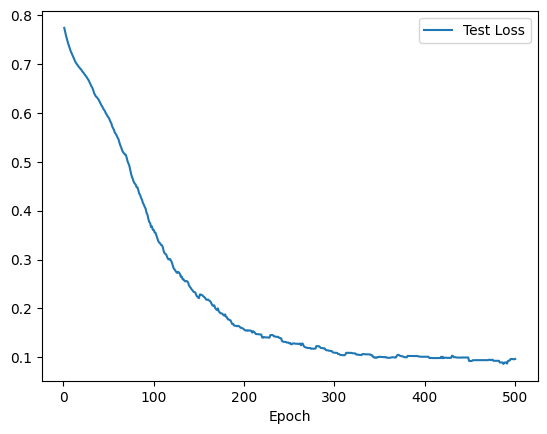

In [9]:
pd.DataFrame(results).plot(x="Epoch", y="Test Loss")

<Axes: xlabel='Epoch'>

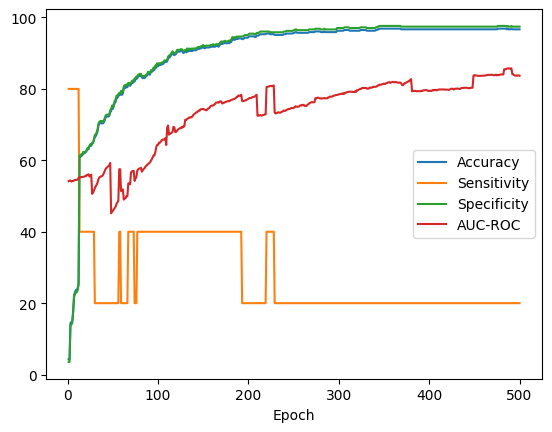

In [10]:
pd.DataFrame(results).plot(x="Epoch", y=["Accuracy", "Sensitivity", "Specificity", "AUC-ROC"])